In [2]:
# Do we actually need all this using statements?
# we need ITensor as we use some functions direclty in the notebook, same for progressmeter
# Potentially, they are automatically included when loading RandomMeas ?
using Revise
using ITensors, ITensorMPS
using RandomMeas
using ProgressMeter # Shall we move it to some script file? The user does not need it explicitly?

## Shallow Shadows 

### Introduction
For a given ensemble of random unitaries $\{u\}$, the measurement or shadow channel $\mathcal{M}$ is defined as $\rho \rightarrow \mathcal{M}(\rho)=\mathbb{E}_u \left[  \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u\right]$ where $\mathbb{E}_u$ denotes the average over the random unitary ensemble. For certain ensembles, in particular local (single-qubit) and global (N-qubit) unitaries from unitary 2-designs, the channel and its inverse $\mathcal{M}^{-1}$ can be computed analytically (Huang et al., Nat. Phys. 2020). We can then use to construct classical shadows for arbitrary input states $\rho$: $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$ where $s$ is the outcome bitstring  of a single computational basis measurement performed on $u\rho u^\dagger$.

For more general ensembles of random unitaries, we need to learn the channel $\mathcal{M}$, then invert it to form shadows and obtain a randomized measurement protocol.

This notebook illustrates this for case of random unitaries formed by shallow random quantum circuits [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), [Akhtar et al., Quantum 7, 1026 (2023)](https://quantum-journal.org/papers/q-2023-06-01-1026), [Bertoni et al, arxiv:2209.12924](https://arxiv.org/abs/2209.12924) and [Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911). Importantly, we use the property that shallow random quantum circuits are locally scrambling circuits. This allows us to learn a representation of the channel from evaluating its action on single initial product state  [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027).

### Needs for a single calibration state for learning and inverting shallow shadows channels

It has been proven with LI unitaries
$$\mathcal{M}(\rho)=\sum_A c_A \rho_A\otimes 1_{\bar{A}}$$

Thus the vector $c_A$ fully specifies the channel $\mathcal{M}(\cdot)$

Let us consider a single calibration state $\rho_0=\ket{0}$. We have the equality (TBC)
$$c_A=\mathrm{tr}_A(\mathcal{M}(\rho_0)O_A)$$
with $O_A=\bigotimes_{i\in A}(\ket{0}\bra{0}-\ket{1}\bra{1})\bigotimes_{i\in \bar{A}}(\ket{1}\bra{1})$. Therefore a single calibration state fully specifies $c_A$ and therefore the channel $\mathcal{M}(\cdot)$. If we assume in addition the channel is invertible, we also end up knowing its inverse. Therefore a single calibration state is sufficient to learn the inverse channel. Numerically, this will be done by minimizing 
$$||\rho_0-\mathcal{M}^{-1}(\sigma_0)||_2^2$$
where $\sigma_0=\mathcal{M}(\rho_0)$ is an MPO representation and the inverse channel is parametrized as
$$\mathcal{M}^{-1}(\sigma)=\sum_A d_A \sigma_A\otimes 1_{\bar{A}}$$
where $d_A=d([s_i=1_{i\in A}],{i=1,\dots,N})$ is written as an MPS.

In [3]:
N = 4 # System size
ξ = siteinds("Qubit", N; addtags="output"); #site indices of the qubits in the system

We begin by picking a set of $N_u$ shallow circuits and calculate numerically the measurement channel $\sigma_0=\mathcal{M}(\rho_0)$ from MPS simulations. Here, $\rho_0=\ket{\psi_0}\bra{\psi_0}$, with $\ket{\psi_0}=\ket{0}^{\otimes N}$. Note that alternatively, one could consider measuring an approximate representation of the channel experimentally ([Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911)).

In [4]:
Nu = 2000 # Number of unitaries
ψ0 = MPS(ξ,["Dn" for n in 1:N]  ); # Initial probe state

random_unitaries = Vector{Vector{ITensor}}()
depth = 2
for r in 1:Nu # For each unitary u, we generate a random circuit of depth 2
    push!(random_unitaries,random_circuit(ξ,depth)) 
end
output_states_ensemble = get_output_state(ψ0,random_unitaries);
# For each unitary u, we evaluate the measurement channel output_state_u 
#= M_u(\psi_0) = \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u. 
# We obtain a vector [M_u(\psi_0)]_u.
#I think we can say in the explanation that we can use a single pure state for that.=#

# I dont understand how to remove this ouput :)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:33


2000-element Vector{MPO}:
 MPO
[1] ((dim=2|id=724|"Qubit,Site,n=1,output")', (dim=2|id=724|"Qubit,Site,n=1,output"), (dim=4|id=56|"Link,n=1"))
[2] ((dim=2|id=526|"Qubit,Site,n=2,output")', (dim=2|id=526|"Qubit,Site,n=2,output"), (dim=8|id=738|"Link,n=1"), (dim=4|id=56|"Link,n=1"))
[3] ((dim=2|id=646|"Qubit,Site,n=3,output")', (dim=2|id=646|"Qubit,Site,n=3,output"), (dim=4|id=651|"Link,n=1"), (dim=8|id=738|"Link,n=1"))
[4] ((dim=2|id=439|"Qubit,Site,n=4,output")', (dim=2|id=439|"Qubit,Site,n=4,output"), (dim=4|id=651|"Link,n=1"))

 MPO
[1] ((dim=2|id=724|"Qubit,Site,n=1,output")', (dim=2|id=724|"Qubit,Site,n=1,output"), (dim=4|id=759|"Link,n=1"))
[2] ((dim=2|id=526|"Qubit,Site,n=2,output")', (dim=2|id=526|"Qubit,Site,n=2,output"), (dim=8|id=305|"Link,n=1"), (dim=4|id=759|"Link,n=1"))
[3] ((dim=2|id=646|"Qubit,Site,n=3,output")', (dim=2|id=646|"Qubit,Site,n=3,output"), (dim=4|id=333|"Link,n=1"), (dim=8|id=305|"Link,n=1"))
[4] ((dim=2|id=439|"Qubit,Site,n=4,output")', (dim=2|id=439|"Qubit

Here we aim to find an MPO $\sigma$, such that $\sigma\approx 1/N_U\sum_u \mathcal{M}_u(\rho_0)$. Here we adapt a compression algorithm [T Baumgratz et al 2013 New J. Phys. 15 125004](https://iopscience.iop.org/article/10.1088/1367-2630/15/12/125004). Our aim is to minimize $d=||\sigma-1/N_U\sum_u \mathcal{M}_u(\rho_0)||^2_2$. This can be done by minimizing the shifted cost function $\mathcal{C}=d-||1/N_U\sum_u \mathcal{M}_u(\rho_0)||^2_2$, which is simpler to evaluate. The compression algorithm updates each tensor $\sigma_i$ sequentially over a finite number of sweeps.

In [5]:
nsweeps = 4 # Number of sweeps for the fitting 
χ = 4 # Bond dimension of the mpo fitted to output state of the measurement channel applied to \psi_0
σ0 = fit_output_MPO(output_states_ensemble,χ,nsweeps);

Cost function -0.02216035009051759
Cost function -0.07179253567235876


Progress:  50%|████████████████████▌                    |  ETA: 0:00:15

Cost function -0.07179333145207482


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:06

Cost function -0.07179376019032649


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Cost function -0.07179396068795385


### Inverting the channel
Now we can then find the inverse map $\mathcal{M}^{-1}(\rho)=\sum_A d_A \rho_A$, such that $\mathcal{M}^{-1}(\mathcal{M})\approx\mathbf{1}$. This is based on automatic-differentation library Zygote and minimizing the cost function $||\rho_0-\mathcal{M}^{-1}(\sigma_0)||^2=||\rho_0-\mathcal{M}^{-1}(\mathcal{M}(\rho_0))||^2$, where the vector $d$ is parametrized as MPS of bond dimension $\chi$

In [29]:
# TODO: The inverse channel, in general, is not uniquely determined by σ0 and \rho0. We need (a complete basis) of input states. I guess we use the local invariance property. Is a single state enough?
# We should  explain how we obtain the representation $\mathcal{M}^{-1}(\rho)=\sum_A d_A \rho_A$. Perhaps we should do this right in the very beginning.
# Yes I agree

In [6]:
#TODO is it necessry to have chi and nsweeps the same values as in the fitting? if not, I would redefine them. 
#OK

d = invert_channel(ψ0,σ0,χ,nsweeps);


#TODO what is the output loss? How do we know whether the inversion was successfull?
#renamed to cost function

sweep 1 cost function 0.004386026810443866
sweep 2 cost function 0.004386017729154479
sweep 3 cost function 0.004386013259720212
sweep 4 cost function 0.004386013149265899


MPS
[1] ((dim=2|id=303|"Qubit,Site,n=1,virtual"), (dim=2|id=197|"Link,l=1"))
[2] ((dim=2|id=91|"Qubit,Site,n=2,virtual"), (dim=2|id=197|"Link,l=1"), (dim=4|id=802|"Link,l=2"))
[3] ((dim=2|id=485|"Qubit,Site,n=3,virtual"), (dim=4|id=802|"Link,l=2"), (dim=2|id=827|"Link,l=3"))
[4] ((dim=2|id=375|"Qubit,Site,n=4,virtual"), (dim=2|id=827|"Link,l=3"))


## Simulated experiment
We are ready to perform an experiment on a unknown state $\psi$, build shadows as MPO and estimate expectation values.

In [7]:
circuit = random_circuit(ξ,depth)
ψ = apply(circuit,ψ0); # We construct some random pure state \psi, our simulated experimental (unknown) state

We perform random measurements in a simulated quantum device.

In [8]:
NM=10
measurement_data = Array{Int,3}(undef,Nu,NM,N)
@showprogress dt=1 for r in 1:Nu
    measurement_data[r,:,:] = get_RandomMeas(ψ,random_unitaries[r],NM) #data acquisition in simulated quantum device
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


We aim to estimate XX correlations. We construct the corresponding MPOs and compute the exact expectation values.

In [9]:
O = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(O,MPO(ampo,ξ))
end

O_exact = Vector{Float64}()
for o in O
    push!(O_exact,real(inner(ψ',o,ψ)))
end

We construct classical shadows and estimate the expectation values.

In [10]:
O_est = Vector{Float64}(undef,N-1);
@showprogress dt=1 for r in 1:Nu
            shadow = get_shallow_shadow(measurement_data[r,:,:],random_unitaries[r],d,ξ)
            for m in 1:NM
               for i in 1:N-1
                    O_est[i] += real(inner(O[i],shadow[m]))/Nu/NM
                end 
            end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


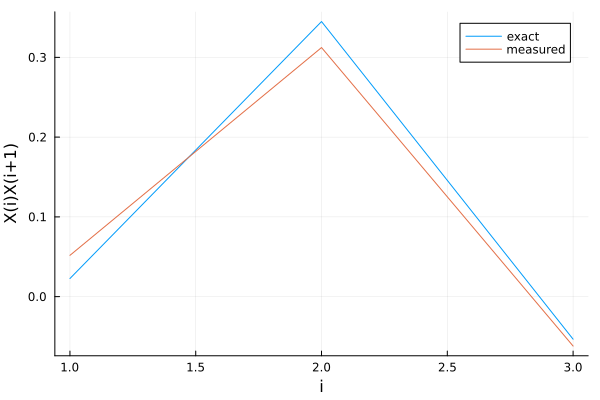

In [11]:
using Plots
plot(O_exact,label="exact")
plot!(O_est,label="measured")
xlabel!("i")
ylabel!("X(i)X(i+1)")